# Training ResNet50 Model

This section will make use of AWS SageMaker ResNet image classification model to train & test ChestXRay model.

In [ ]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'ic-multilabel'
print("Using bucket: " + bucket)

from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print("AWS ResNet training tmage: " + training_image)

This model use images stored in a S3-bucket.

In [ ]:
import boto3
import pandas as pd
import numpy as np

BUCKET_NAME = 'cse6250-chestxray'
s3 = boto3.resource('s3')
s3_bucket = s3.Bucket(BUCKET_NAME)

#### Load training & validation data from pre-process dataset, then update them to appropriate format to be read by SageMaker.

In [ ]:
FILE_FOLDER = '../data/'

train_data = pd.read_csv(FILE_FOLDER + 'train_list.csv', header=0)
val_data = pd.read_csv(FILE_FOLDER + 'val_list.csv', header=0)
test_data = pd.read_csv(FILE_FOLDER + 'test_list.csv', header=0)
with open(FILE_FOLDER + 'labels.txt', 'r') as f:
    labels = f.readlines()

train_result = ""
for index, row in train_data.iterrows():
    result = str(index) + '\t'
    result += '\t'.join(row.values[1:].astype(np.str))
    result += '\t' + str(row.values[0]) + '\n'
    train_result += result
with open('train.lst', 'w') as fp:
    fp.write(train_result)
    fp.close()

val_result = ""
for index, row in val_data.iterrows():
    result = str(index) + '\t'
    result += '\t'.join(row.values[1:].astype(np.str))
    result += '\t' + str(row.values[0]) + '\n'
    val_result += result
with open('val.lst', 'w') as fp:
    fp.write(val_result)
    fp.close()

s3_client = boto3.client('s3')
s3_client.upload_file('train.lst',BUCKET_NAME,'train_list/train.lst')
s3_client.upload_file('val.lst',BUCKET_NAME,'val_list/val.lst')

#### Create the SageMaker training job.

Fixed hyperparameters are:
* use_pretrained_model = 1 (to apply transfer learning)
* num_layers = 50 (to examine ResNet50)
* num_classes = 14
* num_training_samples = 69421
* multi_label = 1

Best performance hyperparameters are found to be:
* image_shape = '3,224,224'
* resize = 256
* learning_rate = 0.0005
* augmentation_type = 'crop_color_transform'
* weight_decay=0.00001
* optimizer='adam'
* precision_dtype='float16'

In [ ]:
s3_output_location = 's3://{}/output'.format(BUCKET_NAME)

multilabel_ic = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 200,
                                         train_max_run = 432000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

multilabel_ic.set_hyperparameters(num_layers=50,
                             use_pretrained_model=1,
                             image_shape = '3,224,224',
                             num_classes=14,
                             mini_batch_size=64,
                             epochs=100,
                             resize=256,
                             learning_rate=0.0005,
                             num_training_samples=69421,
                             use_weighted_loss=1,
                             augmentation_type = 'crop_color_transform',
                             multi_label=1,
                             weight_decay=0.00001,
                             optimizer='adam',
                             precision_dtype='float16')

s3train = 's3://{}/images'.format(BUCKET_NAME)
s3validation = 's3://{}/images'.format(BUCKET_NAME)
s3train_lst = 's3://{}/train_list'.format(BUCKET_NAME)
s3validation_lst = 's3://{}/val_list'.format(BUCKET_NAME)

train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
train_data_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data, 'train_lst': train_data_lst, 
                 'validation_lst': validation_data_lst}

#### Run the training model
SageMaker will save model with highest validation accuracy

In [ ]:
multilabel_ic.fit(inputs=data_channels, logs=True)

#### Deploy trained model to an endpoint

In [ ]:
ic_classifier = multilabel_ic.deploy(initial_instance_count = 1, instance_type = 'ml.t2.medium')
ic_classifier.content_type = 'application/x-image'

#### Run classification on test data

In [ ]:
import json
import os
import csv

IMAGE_FOLDER = '../data/images/'

predict = []
truth = []

for index, row in test_data.iterrows():
    with open(IMAGE_FOLDER + row.values[0], 'wb') as data:
        s3_bucket.download_fileobj('images/' + row.values[0], data)
    with open(IMAGE_FOLDER + row.values[0], 'rb') as image:
        f = image.read()
        b = bytearray(f)
    results = ic_classifier.predict(b)
    prob = json.loads(results)
    predict.append(prob)
    truth.append(row.values[1:])
    #os.remove('images/' + row.values[0])

truth = [arr.tolist() for arr in truth]

#### Evaluate classification result
Evaluate Area Under ROC Curve metric for each class

Plotting ROC curves:


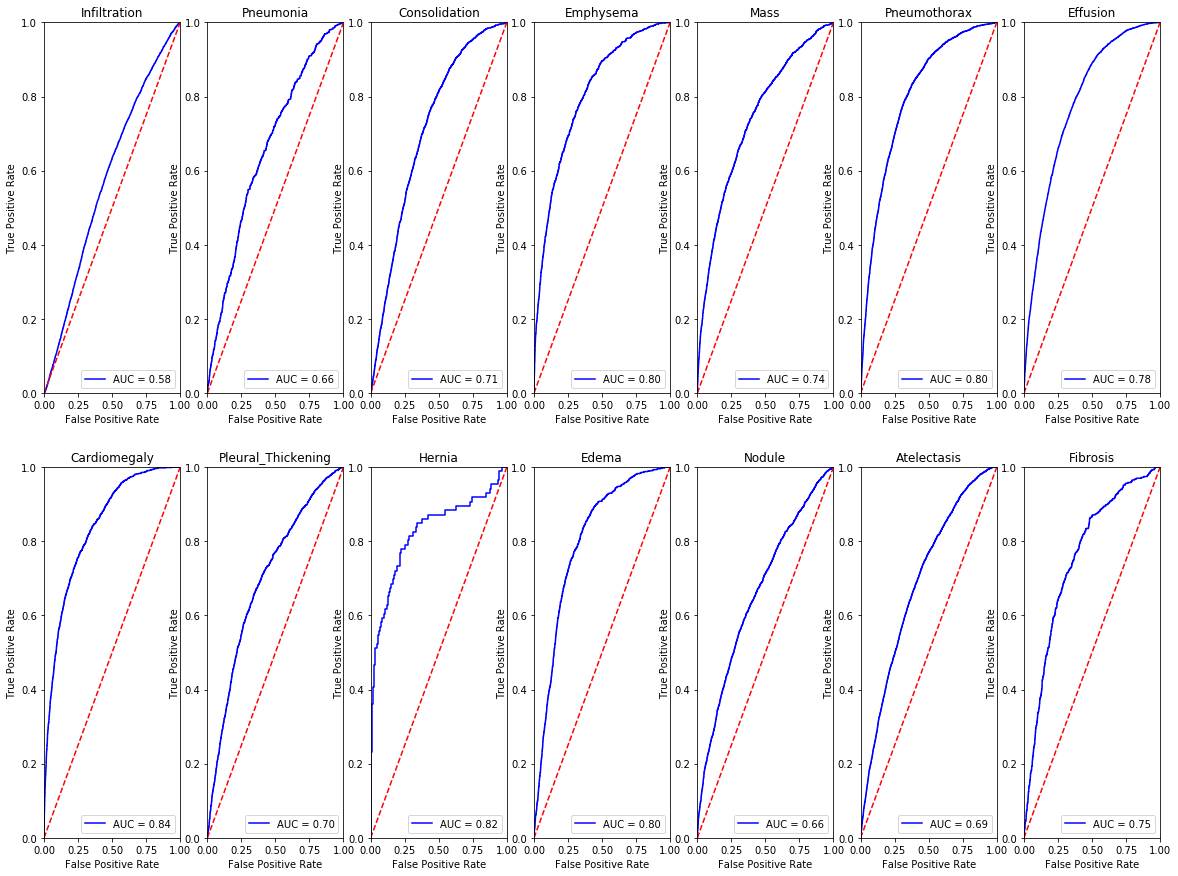

In [34]:
from sklearn import metrics
import matplotlib.pyplot as plt

auc_list = []
fpr_list = []
tpr_list = []
truth_list = []
predict_list = []

for i in range(14):
    each_truth = [x[i] for x in truth]
    each_predict = [y[i] for y in predict]
    fpr, tpr, thresholds = metrics.roc_curve(each_truth, each_predict)
    each_auc = metrics.auc(fpr, tpr)
    truth_list.append(each_truth)
    predict_list.append(each_predict)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(each_auc)

print("Plotting ROC curves:")

# create figure with sub-plots
fig, axes = plt.subplots(2, 7, figsize=(20,15))
for i, ax in enumerate(axes.flat):
    ax.plot(fpr_list[i], tpr_list[i], 'b', label = 'AUC = %0.2f' % auc_list[i])
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(labels[i])
plt.show()

Plotting AUCs:


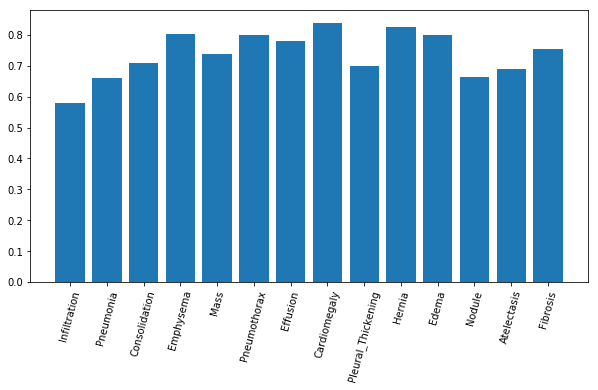

In [35]:
print("Plotting AUCs:")

plt.figure(figsize=(10,5))
plt.bar(labels, auc_list)
plt.xticks(rotation=75)
plt.show()

Thresholds can further be refined to enhance performance.

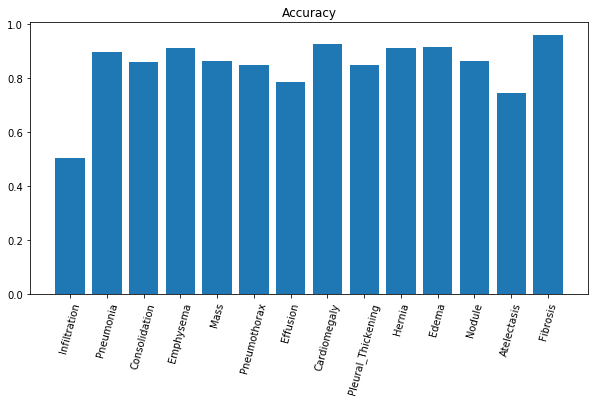

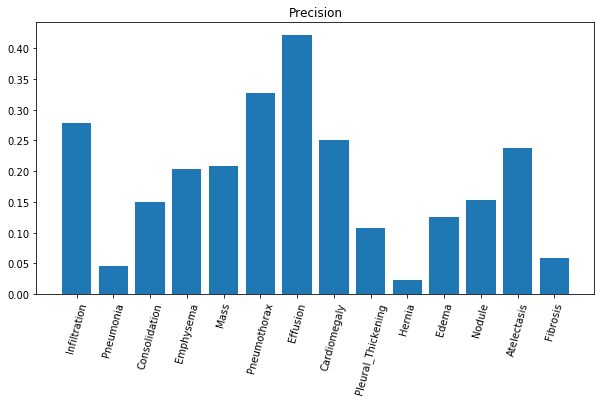

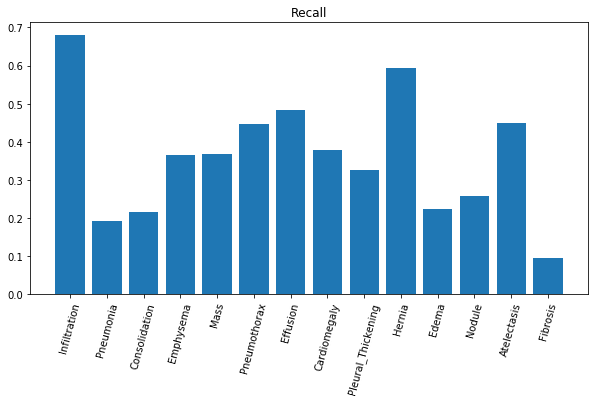

In [201]:
pred_0 = [int(z > 0.65) for z in predict_list[0]]
pred_1 = [int(z > 0.8) for z in predict_list[1]]
pred_2 = [int(z > 0.87) for z in predict_list[2]]
pred_3 = [int(z > 0.87) for z in predict_list[3]]
pred_4 = [int(z > 0.82) for z in predict_list[4]]
pred_5 = [int(z > 0.8) for z in predict_list[5]]
pred_6 = [int(z > 0.89) for z in predict_list[6]]
pred_7 = [int(z > 0.93) for z in predict_list[7]]
pred_8 = [int(z > 0.76) for z in predict_list[8]]
pred_9 = [int(z > 0.84) for z in predict_list[9]]
pred_10 = [int(z > 0.89) for z in predict_list[10]]
pred_11 = [int(z > 0.63) for z in predict_list[11]]
pred_12 = [int(z > 0.77) for z in predict_list[12]]
pred_13 = [int(z > 0.63) for z in predict_list[13]]
predict_label_list = [pred_0, pred_1, pred_2, pred_3, pred_4, pred_5, pred_6, pred_7, pred_8, pred_9, pred_10, pred_11, pred_12, pred_13]

accuracy_list = []
precision_list = []
recall_list = []

for i in range(14):
    accuracy = metrics.accuracy_score(truth_list[i], predict_label_list[i])
    accuracy_list.append(accuracy)
    precision = metrics.precision_score(truth_list[i], predict_label_list[i])
    precision_list.append(precision)
    recall = metrics.recall_score(truth_list[i], predict_label_list[i])
    recall_list.append(recall)

plt.figure(figsize=(10,5))
plt.bar(labels, accuracy_list)
plt.title("Accuracy")
plt.xticks(rotation=75)
plt.show()

plt.figure(figsize=(10,5))
plt.bar(labels, precision_list)
plt.title("Precision")
plt.xticks(rotation=75)
plt.show()

plt.figure(figsize=(10,5))
plt.bar(labels, recall_list)
plt.title("Recall")
plt.xticks(rotation=75)
plt.show()

In [ ]:
ic_classifier.delete_endpoint()